This kernel is forked from Andrew's Pytorch Kernel https://www.kaggle.com/artgor/segmentation-in-pytorch-using-convenient-tools

I have done a couple things to speed things up and allow for larger models. The first one is that I <b>resized the dataset before hand so that we do not need to do this repetitively for each epoch</b>. This takes our epoch time down from ~23 minutes down to ~7 minutes using the same resnet 50 unet architecture. You can do whatever you like with this additional time, train more models, more epochs, larger backbones, etc. 

The second thing I have done is <b>add in nvidia apex so we can do mixed precision training</b>. This roughly halves memory usage on the GPU and allows us to fit larger models or larger batch sizes. 

This has allowed me to train the larger se_resnext101_32x4d backbone in a shorter amount of time while also getting a better score.  

In [1]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch
!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ../input/apex-325f5a0/apex-master/
from apex import amp

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-ll0jsunv
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-ll0jsunv
     |████████████████████████████████| 61kB 2.4MB/s 
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.0.3-cp36-none-any.whl size=30054 sha256=332adc778dcbd0d0e52b9a0393624a607c68b7508333423febf72ff1376a4bee
  Stored in directory: /tmp/pip-ephem-wheel-cache-q62vs747/wheels/79/3f/09/1587a252e0314d26ad242d6d2e165622ab95c95e5cfe4b942c
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=16187372c92eeef22a1820b2cda8730044ff1ac7aa3f55fab589c52b97ed0777
  Stored in directory: /tmp/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.4.0-cp36-none-any.whl size=11149 sha256=3a0d38741ab1fbe7823919b4e766

## Importing and parameters

In [2]:
import os, gc, time, json, copy
import pickle, random, itertools, collections
import tqdm
from functools import partial

import numpy as np
import pandas as pd
from PIL import Image
import cv2

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score

import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import albumentations as albu
from albumentations import pytorch as AT

import segmentation_models_pytorch as smp

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 2019

# Data parameters
path = '../input/understanding_cloud_organization'
img_paths = '../input/understanding-clouds-resized'
n_splits = 5
which_fold = 0  # should be int in [0, n_splits-1]

# Learning parameters
batch_size = 32
lr = 1e-2

## Helper functions and classes

In [4]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))


def get_img(x, folder: str='train_images_525/train_images_525'):
    """
    Return image based on image name and folder.
    """
    data_folder = f"{img_paths}/{folder}"
    image_path = os.path.join(data_folder, x)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    """
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

def make_mask(image_name: str='img.jpg', shape: tuple=(350, 525)):
    "Create mask (ndarray, values between 0-1) based on image name and shape."
    masks = np.zeros((shape[0], shape[1], 4), dtype=np.float32)
    for classidx, classid in enumerate(["Fish", "Flower", "Gravel", "Sugar"]):
        mask = cv2.imread("../input/understanding-clouds-resized/train_masks_525/train_masks_525/" + classid + image_name)
        if mask is None:
            continue
        if mask[:,:,0].shape != (350,525):
            mask = cv2.resize(mask, (525,350))
        masks[:, :, classidx] = mask[:,:,0]
    masks = masks / 255
    return masks

def mask2rle(img):
    """
    Convert mask to rle.
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    """
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def visualize(image, mask, original_image=None, original_mask=None):
    """
    Plot images and masks.
    
    Input
    - image: ndarray image loaded from cv2
    - mask: ndarray output from make_mask
    - original ones: If given, show them all
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 5, figsize=(24, 24))

        ax[0].imshow(image)
        for i in range(4):
            ax[i + 1].imshow(mask[:, :, i])
            ax[i + 1].set_title(f'Mask {class_dict[i]}', fontsize=fontsize)
    else:
        f, ax = plt.subplots(2, 5, figsize=(24, 12))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
                
        for i in range(4):
            ax[0, i + 1].imshow(original_mask[:, :, i])
            ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)
        
        ax[1, 0].imshow(image)
        ax[1, 0].set_title('Transformed image', fontsize=fontsize)
        
        
        for i in range(4):
            ax[1, i + 1].imshow(mask[:, :, i])
            ax[1, i + 1].set_title(f'Transformed mask {class_dict[i]}', fontsize=fontsize)
            
            
def visualize_with_raw(image, mask, original_image=None, original_mask=None, raw_image=None, raw_mak=None):
    """
    Plot images and masks.
    
    Input
    - image: ndarray image loaded from cv2
    - mask: ndarray output from make_mask
    - original ones / raw ones: If given, show them all
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}

    f, ax = plt.subplots(3, 5, figsize=(24, 12))

    ax[0, 0].imshow(original_image)
    ax[0, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[0, i + 1].imshow(original_mask[:, :, i])
        ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)


    ax[1, 0].imshow(raw_image)
    ax[1, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[1, i + 1].imshow(raw_mak[:, :, i])
        ax[1, i + 1].set_title(f'Raw predicted mask {class_dict[i]}', fontsize=fontsize)
        
    ax[2, 0].imshow(image)
    ax[2, 0].set_title('Transformed image', fontsize=fontsize)


    for i in range(4):
        ax[2, i + 1].imshow(mask[:, :, i])
        ax[2, i + 1].set_title(f'Predicted mask with processing {class_dict[i]}', fontsize=fontsize)
            
            
def plot_with_augmentation(image, mask, augment):
    """
    Plot images, masks and augmentation results.
    
    Input
    - image: ndarray image loaded from cv2
    - mask: ndarray output from make_mask
    - augment: transformation from albumentations
    """
    augmented = augment(image=image, mask=mask)
    image_flipped = augmented['image']
    mask_flipped = augmented['mask']
    visualize(image_flipped, mask_flipped, original_image=image, original_mask=mask)


def post_process(probability, threshold, min_size):
    """
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    
    Input
    - probability: predicted probability mask, ndarray (350, 525)
    - threshold: value to binarize probability mask
    - min_size: ??
    """
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((350, 525), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

def get_training_augmentation():
    train_transform = [
        albu.Resize(256, 384),
#         albu.Resize(320, 640),
#         albu.Resize(448, 448),  # 320,640  350,525  352,512
        albu.HorizontalFlip(),
        albu.VerticalFlip(),
#         albu.RandomRotate90(),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, border_mode=0)
#         albu.GridDistortion(p=0.5),
#         albu.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5),

    ]
    return albu.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
#         albu.Resize(448, 448),  # 320,640  350,525  352,512
#         albu.Resize(320, 640)
        albu.Resize(256, 384)
    ]
    return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


def compute_dice(img1, img2):
    img1 = np.asarray(img1).astype(np.bool)
    img2 = np.asarray(img2).astype(np.bool)

    intersection = np.logical_and(img1, img2)

    return 2. * intersection.sum() / (img1.sum() + img2.sum())

## Data overview

Let's have a look at the data first.
We have folders with train and test images, file with train image ids and masks and sample submission.

In [5]:
train = pd.read_csv(f'{path}/train.csv')
sub = pd.read_csv(f'{path}/sample_submission.csv')

In [6]:
n_train = len(os.listdir(f'{img_paths}/train_images_525/train_images_525'))
n_test = len(os.listdir(f'{img_paths}/test_images_525/test_images_525'))
print(f'There are {n_train} images in train dataset')
print(f'There are {n_test} images in test dataset')

There are 5546 images in train dataset
There are 3698 images in test dataset


## Preparing data for modelling

At first, let's create a list of unique image ids and the count of masks for images. This will allow us to make a stratified split based on this count.

In [7]:
id_mask_count = (train.loc[~train['EncodedPixels'].isnull(), 'Image_Label']
                    .apply(lambda x: x.split('_')[0])
                    .value_counts()
                    .reset_index()
                    .rename(columns={'index': 'img_id', 'Image_Label': 'count'}))

train_ids, valid_ids = train_test_split(id_mask_count['img_id'].values, random_state=42, stratify=id_mask_count['count'], test_size=0.1)
test_ids = sub['Image_Label'].apply(lambda x: x.split('_')[0]).drop_duplicates().values

In [8]:
def train_val_split(id_mask_count, which_fold=None):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    cv_indices = [(tr_idx, val_idx) for tr_idx, val_idx in kf.split(id_mask_count['img_id'], id_mask_count['count'])]
    if which_fold is not None:
        return [cv_indices[which_fold]]
    return cv_indices

In [9]:
len(train_ids), len(valid_ids)

(4991, 555)

In [10]:
id_mask_count

,img_id,count
0,34cfd98.jpg,4
1,547a232.jpg,4
2,fdf4645.jpg,4
3,6851470.jpg,4
4,cca407c.jpg,4
...,...,...
5541,7273621.jpg,1
5542,42467ad.jpg,1
5543,573e737.jpg,1
5544,538eb3e.jpg,1


In [11]:
id_mask_count['count'].value_counts()

2    2372
3    1560
1    1348
4     266
Name: count, dtype: int64

There are a lot of empty masks. In fact only 266 images have all four masks. It is important to remember this.

## Setting up data loader, model, solver

In [12]:
class CloudDataset(Dataset):
    def __init__(self, dataset_type: str='train', img_ids: np.array=None,
                 transforms=albu.Compose([albu.HorizontalFlip(), AT.ToTensor()]),
                 preprocessing=None, label_smooth=0):
        if dataset_type != 'test':
            self.data_folder = f"{img_paths}/train_images_525/train_images_525"
        else:
            self.data_folder = f"{img_paths}/test_images_525/test_images_525"
        self.img_ids = img_ids
        self.transforms = transforms
        self.preprocessing = preprocessing
        self.label_smooth = label_smooth

    def __getitem__(self, idx):
        image_name = self.img_ids[idx]
        mask = make_mask(image_name)
        img = cv2.imread(os.path.join(self.data_folder, image_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']
        if self.label_smooth > 0:
            mask = np.where(mask==1, 1-label_smooth, label_smooth).astype('float32')
        if self.preprocessing:
            preprocessed = self.preprocessing(image=img, mask=mask)
            img = preprocessed['image']
            mask = preprocessed['mask']
        return img, mask

    def __len__(self):
        return len(self.img_ids)

In [13]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = None

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

def model_optimizer_init(ft_lrs, num_labels=4):
    print("Building model and optimizer...")
    model = smp.FPN(
        encoder_name=ENCODER, 
        encoder_weights=ENCODER_WEIGHTS, 
        classes=4, 
        activation=ACTIVATION
    )
    param_g1 = [p for c in list(model.encoder.children())[:5] for p in c.parameters()]
    param_g2 = [p for c in list(model.encoder.children())[5:] for p in c.parameters()]
    optimizer = torch.optim.Adam([
        {'params': param_g1, 'lr': ft_lrs[0]},
        {'params': param_g2, 'lr': ft_lrs[1]}, 
        {'params': model.decoder.parameters(), 'lr': ft_lrs[2]},
#         {'params': model.encoder.parameters(), 'lr': ft_lrs[0]}, 
#         {'params': model.decoder.parameters(), 'lr': ft_lrs[1]},
    ])
    return model, optimizer

In [14]:
class OneCycleScheduler(object):
    # one-cycle scheduler
    SCHEDULES = set(['cosine', 'linear', 'linear_cosine'])

    def __init__(self, optimizer, iterations, sched_profile='cosine', max_lr=3e-3,
                 moms=(.95, .85), div_factor=25, warmup=0.3, final_div=None):

        self.optimizer = optimizer
        assert sched_profile in self.SCHEDULES
        self.sched_profile = sched_profile

        if isinstance(max_lr, list) or isinstance(max_lr, tuple):
            if len(max_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} max_lr, got {}".format(
                    len(optimizer.param_groups), len(max_lr)))
            self.max_lrs = list(max_lr)
            self.init_lrs = [lr/div_factor for lr in self.max_lrs]
        else:
            self.max_lrs = [max_lr] * len(optimizer.param_groups)
            self.init_lrs = [max_lr/div_factor] * len(optimizer.param_groups)

        self.final_div = final_div
        if self.final_div is None: self.final_div = div_factor*1e4
        self.final_lrs = [lr/self.final_div for lr in self.max_lrs]
        self.moms = moms

        self.total_iteration = iterations
        self.up_iteration = int(self.total_iteration * warmup)
        self.down_iteration = self.total_iteration - self.up_iteration

        self.curr_iter = 0
        self._assign_lr_mom(self.init_lrs, [moms[0]]*len(optimizer.param_groups))

    def _assign_lr_mom(self, lrs, moms):
        for param_group, lr, mom in zip(self.optimizer.param_groups, lrs, moms):
            param_group['lr'] = lr
            param_group['betas'] = (mom, 0.999)

    def _annealing_cos(self, start, end, pct):
        cos_out = np.cos(np.pi * pct) + 1
        return end + (start-end)/2 * cos_out

    def _annealing_linear(self, start, end, pct):
        return start + pct * (end-start)
    
    def _annealing_function(self, curr_iter):
        if self.sched_profile == 'cosine':
            return self._annealing_cos
        if self.sched_profile == 'linear':
            return self._annealing_linear
        if self.sched_profile == 'linear_cosine':
            if curr_iter <= self.up_iteration:
                return self._annealing_linear
            else:
                return self._annealing_cos
    
    def step(self):
        self.curr_iter += 1
        anneal = self._annealing_function(self.curr_iter)

        if self.curr_iter <= self.up_iteration:
            pct = self.curr_iter / self.up_iteration
            curr_lrs = [anneal(min_lr, max_lr, pct) \
                            for min_lr, max_lr in zip(self.init_lrs, self.max_lrs)]
            curr_moms = [anneal(self.moms[0], self.moms[1], pct) \
                            for _ in range(len(self.optimizer.param_groups))]
        else:
            pct = (self.curr_iter-self.up_iteration) / self.down_iteration
            curr_lrs = [anneal(max_lr, final_lr, pct) \
                            for max_lr, final_lr in zip(self.max_lrs, self.final_lrs)]
            curr_moms = [anneal(self.moms[1], self.moms[0], pct) \
                            for _ in range(len(self.optimizer.param_groups))]

        self._assign_lr_mom(curr_lrs, curr_moms)

def lr_range_test(train_loader, model, optimizer, criterion, start_lr=1e-7,
                  end_lr=10, num_it=100, stop_div=True):
    epochs = int(np.ceil(num_it/len(train_loader)))
    n_groups = len(optimizer.param_groups)

    if isinstance(start_lr, list) or isinstance(start_lr, tuple):
        if len(start_lr) != n_groups:
            raise ValueError("expected {} max_lr, got {}".format(n_groups, len(start_lr)))
        start_lrs = list(start_lr)
    else:
        start_lrs = [start_lr] * n_groups

    if isinstance(end_lr, list) or isinstance(end_lr, tuple):
        if len(end_lr) != n_groups:
            raise ValueError("expected {} max_lr, got {}".format(n_groups, len(end_lr)))
        end_lrs = list(end_lr)
    else:
        end_lrs = [end_lr] * n_groups

    curr_lrs = start_lrs*1
    for param_group, lr in zip(optimizer.param_groups, curr_lrs):
        param_group['lr'] = lr

    n, lrs_logs, loss_log = 0, [], []

    for e in range(epochs):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device=device, dtype=torch.float), y.to(device=device, dtype=torch.float)
            scores = model(x)
            loss = criterion(scores, y)

            optimizer.zero_grad()
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
#             loss.backward()
            optimizer.step()

            lrs_logs.append(curr_lrs)
            loss_log.append(loss.item())

            # update best loss
            if n == 0:
                best_loss, n_best = loss.item(), n
            else:
                if loss.item() < best_loss:
                    best_loss, n_best = loss.item(), n

            # update lr per iter with exponential schedule
            n += 1
            curr_lrs = [lr * (end_lr/lr) ** (n/num_it) for lr, end_lr in zip(start_lrs, end_lrs)]
            for param_group, lr in zip(optimizer.param_groups, curr_lrs):
                param_group['lr'] = lr

            # stopping condition
            if n == num_it or (stop_div and (loss.item() > 4*best_loss or torch.isnan(loss))):
                break

    print('minimum loss {}, at lr {}'.format(best_loss, lrs_logs[n_best]))
    return lrs_logs, loss_log

In [15]:
train_dataset = CloudDataset(dataset_type='train', img_ids=train_ids,
                             transforms=get_training_augmentation(),
                             preprocessing=get_preprocessing(preprocessing_fn))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

/opt/conda/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:2567: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn('Using lambda is incompatible with multiprocessing. '


In [16]:
%%time
ft_lrs = [0.0025*lr, 0.05*lr, lr]
model, optimizer = model_optimizer_init(ft_lrs)
model = model.to(device)
criterion = smp.utils.losses.BCEDiceLoss(eps=1.).to(device)
model, optimizer = amp.initialize(model, optimizer, opt_level="O1", verbosity=0)

Building model and optimizer...


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 130MB/s]


CPU times: user 4.43 s, sys: 1.7 s, total: 6.12 s
Wall time: 9.02 s


In [17]:
print(str(torch.cuda.memory_allocated(device)/1e6 ) + 'M')
print(str(torch.cuda.memory_cached(device)/1e6 ) + 'M')
torch.cuda.empty_cache()

95.471616M
115.34336M


In [18]:
lrs_logs, loss_log = lr_range_test(train_loader, model, optimizer, criterion, start_lr=(2.5e-10,5e-9,1e-7), end_lr=(0.025,0.5,10))
lrs_logs = list(zip(*lrs_logs))

minimum loss 0.8781253099441528, at lr [5.727169131919437e-05, 0.0011454338263838873, 0.022908676527677745]


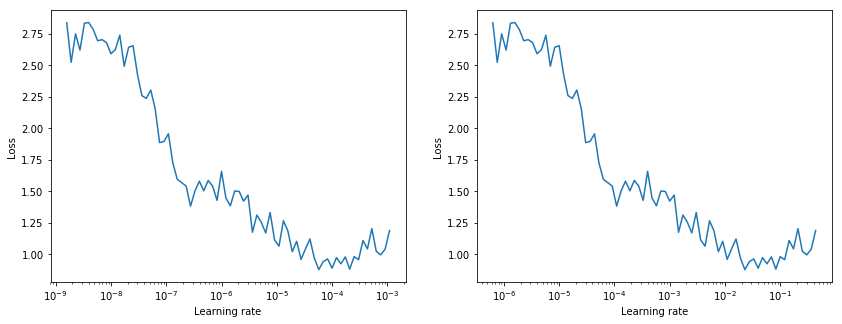

In [19]:
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(lrs_logs[0][10:-3], loss_log[10:-3])
ax1.set_xscale('log')
ax1.set_xlabel('Learning rate')
ax1.set_ylabel('Loss')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(lrs_logs[-1][10:-3], loss_log[10:-3])
ax2.set_xscale('log')
ax2.set_xlabel('Learning rate')
ax2.set_ylabel('Loss');